#Tarefa 2 - TD semigradiente com rede neural
Bem-vindo à tarefa 2 de programação do curso 3. Na tarefa anterior, você implementou TD semigradiente com agregação de estado para resolver uma tarefa de avaliação de política. Nesta tarefa, você implementará TD semigradiente com uma rede neural simples e a usará para o mesmo problema de avaliação de política.

Você implementará um agente para avaliar uma política fixa no passeio aleatório de 500 estados. Como você deve se lembrar da tarefa anterior, o Passeio Aleatório de 500 estados inclui 500 estados. Cada episódio começa com o agente no centro e termina quando o agente vai para a esquerda além do estado 1 ou para a direita além do estado 500. Em cada intervalo de tempo, o agente escolhe se mover para a esquerda ou para a direita com igual probabilidade. O ambiente determina o quanto o agente se move na direção selecionada.

Nesta tarefa, você irá:

Implementar método estocástico de descida gradiente para previsão de valor de estado.
Implemente TD semigradiente com uma rede neural como aproximador de função e algoritmo de Adam.
Compare o desempenho do TD semigradiente com uma rede neural e do TD semigradiente com codificação em blocos.


## Packages
We import the following libraries that are required for this assignment:

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.
- [RL-Glue](http://www.jmlr.org/papers/v10/tanner09a.html) : Library for reinforcement learning experiments.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments.
- BaseOptimizer : An abstract class that specifies the optimizer API for Agent.
- plot_script : Custom script to plot results.
- RandomWalkEnvironment : The Randomwalk environment script from Course 3 Assignment 1.

In [ ]:
# Do not modify this cell!

# Import necessary libraries
# DO NOT IMPORT OTHER LIBRARIES - This will break the autograder.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os, shutil
from tqdm import tqdm

from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent
from optimizer import BaseOptimizer
import plot_script
from randomwalk_environment import RandomWalkEnvironment

## Seção 1: Criar TD semigradiente com uma rede neural
Nesta seção, você implementará um Agente que aprende com TD semigradiente com uma rede neural. Você usará uma rede neural com uma camada oculta. A entrada da rede neural é a codificação one-hot do número do estado. Usamos a codificação one-hot do número do estado em vez do próprio número do estado porque não queremos construir o conhecimento prévio de que entradas de números inteiros próximas umas das outras têm valores semelhantes. A camada oculta contém 100 unidades lineares retificadoras (ReLUs) que passam sua entrada se for maior que um e retornam 0 caso contrário. As portas ReLU são comumente usadas em redes neurais devido às suas boas propriedades, como a dispersão da ativação e os gradientes que não desaparecem. A saída da rede neural é o valor do estado estimado. É uma função linear das unidades ocultas, como é comumente o caso ao estimar o valor de um alvo contínuo usando redes neurais.

Para uma determinada entrada, $s$, o valor de $s$ é calculado por:
$$
\begin{align}
\psi &= sW^{[0]} + b^{[0]} \\
x &= \textit{max}(0, \psi) \\
v &= xW^{[1]} + b^{[1]}
\end{align}
$$

Onde $W^{[0]}$, $b^{[0]}$, $W^{[1]}$, $b^{[1]}$  são os parâmetros da rede e serão aprendidos no treinamento do agente.

## 1-1: Implementar métodos auxiliares

Antes de implementar o agente, você primeiro implementa algumas funções auxiliares que serão usadas posteriormente nos métodos principais do agente.

### Implementar `get_value()`
Primeiro, você implementará o método get_value() que alimenta uma entrada $s$ na rede neural e retorna a saída da rede $v$ de acordo com as equações acima. Para implementar get_value(), leve em consideração as seguintes notas:

- `get_value()` obtém o número do estado codificado one-hot indicado por s como entrada.
- `get_value()` recebe como entrada os pesos da rede neural, denotados por pesos e estruturados como um array de dicionários. Cada dicionário corresponde a pesos de uma camada da rede neural para a próxima. Cada dicionário inclui $W$ e $b$. A forma dos elementos nos pesos é a seguinte:
 - weights[0]["W"]: num_states $\times$ num_hidden_units
 - weights[0]["b"]: 1 $\vezes$ num_hidden_units
 - weights[1]["W"]: num_hidden_units $\vezes$ 1
 - weights[1]["b"]: 1 $\vezes$ 1

- A entrada da rede neural é um vetor esparso. Para tornar a computação mais rápida, aproveitamos a escassez de entrada. Para fazer isso, fornecemos um método auxiliar `my_matmul()`. **Certifique-se de usar `my_matmul()` para todas as multiplicações de matrizes, exceto para multiplicações por elemento neste notebook.**
- O operador max usado para calcular $x$ é elemento a elemento.

In [ ]:
def my_matmul(x1, x2):
    """
    Given matrices x1 and x2, return the multiplication of them
    """

    # Inicializa a matriz de resultado com zeros, com a forma apropriada
    result = np.zeros((x1.shape[0], x2.shape[1]))

    # Obtém os índices dos elementos não zero em x1
    x1_non_zero_indices = x1.nonzero()

    # Verifica se x1 é uma matriz linha com um único elemento não zero
    if x1.shape[0] == 1 and len(x1_non_zero_indices[1]) == 1:
        # O resultado é a linha correspondente de x2 multiplicada pelo valor não zero de x1
        result = x2[x1_non_zero_indices[1], :]
    # Verifica se x1 é uma matriz coluna com um único elemento não zero
    elif x1.shape[1] == 1 and len(x1_non_zero_indices[0]) == 1:
        # Multiplica x2 pelo valor não zero de x1 e atribui à linha correspondente de result
        result[x1_non_zero_indices[0], :] = x2 * x1[x1_non_zero_indices[0], 0]
    else:
        # Se nenhuma das condições acima for atendida, realiza a multiplicação de matrizes usual
        result = np.matmul(x1, x2)

    return result

In [ ]:
def get_value(s, weights):
    """
    Alimenta uma entrada de estado na rede neural e retorna o valor estimado do estado.

    Argumentos:
    s: vetor one-hot representando o estado [numpy array]
    weights: lista de dicionários contendo os pesos da rede neural

    Retorna:
    valor estimado do estado [float]
    """
    # Feedforward na rede neural
    hidden_layer_input = my_matmul(s, weights[0]["W"]) + weights[0]["b"]

     # ReLU activation
    hidden_layer_output = np.maximum(0, hidden_layer_input)

    output_layer_input = my_matmul(hidden_layer_output, weights[1]["W"]) + weights[1]["b"]
     # O resultado é um array de uma única entrada
    v = output_layer_input.item()

    return v

Run the following code to test your implementation of the `get_value()` function:

In [ ]:
# Suppose num_states = 5, num_hidden_layer = 1, and num_hidden_units = 10
num_hidden_layer = 1
s = np.array([[0, 0, 0, 1, 0]])

weights_data = np.load("/content/get_value_weights.npz")
weights = [dict() for i in range(num_hidden_layer+1)]
weights[0]["W"] = weights_data["W0"]
weights[0]["b"] = weights_data["b0"]
weights[1]["W"] = weights_data["W1"]
weights[1]["b"] = weights_data["b1"]

estimated_value = get_value(s, weights)
print ("Estimated value: {}".format(estimated_value))

assert(np.allclose(estimated_value, [[-0.21915705]]))

Estimated value: -0.21915704884972553


**Expected output**:

    Estimated value: [[-0.21915705]]

### Implementar `get_gradient()`
Você também implementará o método `get_gradient()` que calcula o gradiente da função de valor para uma determinada entrada, usando retropropagação. Posteriormente, você usará esta função para atualizar a função de valor.

Como você sabe, calculamos o valor de um estado $s$ de acordo com:
$$
\begin{align}
\psi &= sW^{[0]} + b^{[0]} \\
x &= \textit{max}(0, \psi) \\
v &= xW^{[1]} + b^{[1]}
\end{align}
$$

Para atualizar os pesos da rede neural ($W^{[0]}$, $b^{[0]}$, $W^{[1]}$, $b^{[1]}$), calculamos o gradiente de $v$ em relação aos pesos de acordo com:

$$
\begin{align}
\frac{\partial v}{\partial W^{[0]}} &= s^T(W^{[1]T} \odot I_{x>0}) \\
\frac{\partial v}{\partial b^{[0]}} &= W^{[1]T} \odot I_{x>0} \\
\frac{\partial v}{\partial W^{[1]}} &= x^T \\
\frac{\partial v}{\partial b^{[1]}} &= 1
\end{align}
$$
onde $\odot$ denota a multiplicação de matriz elemento a elemento e $I_{x>0}$ é o gradiente da função de ativação ReLU que é um indicador cujo $i$-ésimo elemento é 1 se $x[i]>0$ e 0 caso contrário.

In [ ]:
def get_gradient(s, weights):
    """
    Dadas as entradas s e os pesos, retorne o gradiente de v em relação aos pesos

    Um gradiente é um vetor que  indica a direção e a taxa de variação mais rápidas
    de uma função em um ponto específico no espaço multidimensional.
    """

    # Inicializa uma lista de dicionários para armazenar os gradientes para cada camada
    grads = [dict() for i in range(len(weights))]

    # Feedforward para calcular as ativações
    # Calcula a entrada para a camada oculta
    hidden_layer_input = my_matmul(s, weights[0]["W"]) + weights[0]["b"]

     # Aplica a função de ativação ReLU na camada oculta
    hidden_layer_output = np.maximum(0, hidden_layer_input)

    # Calcula a entrada para a camada de saída
    output_layer_input = my_matmul(hidden_layer_output, weights[1]["W"]) + weights[1]["b"]

    # Converte o array de saída em um único valor
    state_value = output_layer_input.item()

    # Backpropagation para calcular os gradientes
    # Gradiente da camada de saída
    d_output_layer_input = 1  # Derivada da saída em relação a si mesma é 1

    # Gradiente de W1 com relação à saída
    grads[1]["W"] = hidden_layer_output.T * d_output_layer_input

    # Gradiente de b1 com relação à saída, deve ter o mesmo formato que weights[1]["b"]
    grads[1]["b"] = np.array([[d_output_layer_input]])

     # Gradiente da saída da camada oculta
    d_hidden_layer_output = weights[1]["W"].T * d_output_layer_input

    # Derivada da ReLU
    d_hidden_layer_input = d_hidden_layer_output * (hidden_layer_input > 0)

    # Gradiente de W0 com relação à entrada
    grads[0]["W"] = my_matmul(s.T, d_hidden_layer_input)

    # Gradiente de b0 com relação à entrada
    grads[0]["b"] = d_hidden_layer_input

    return grads  # Retorna os gradientes calculados

Run the following code to test your implementation of the `get_gradient()` function:

In [ ]:
# Suppose num_states = 5, num_hidden_layer = 1, and num_hidden_units = 2
num_hidden_layer = 1
s = np.array([[0, 0, 0, 1, 0]])

weights_data = np.load("/content/get_gradient_weights.npz")
weights = [dict() for i in range(num_hidden_layer+1)]
weights[0]["W"] = weights_data["W0"]
weights[0]["b"] = weights_data["b0"]
weights[1]["W"] = weights_data["W1"]
weights[1]["b"] = weights_data["b1"]

grads = get_gradient(s, weights)

grads_answer = np.load("/content/get_gradient_grads.npz")

assert(np.allclose(grads[0]["W"], grads_answer["W0"]))
assert(np.allclose(grads[0]["b"], grads_answer["b0"]))
assert(np.allclose(grads[1]["W"], grads_answer["W1"]))
assert(np.allclose(grads[1]["b"], grads_answer["b1"]))

**Expected output**:

    grads[0]["W"]
     [[0.         0.        ]
     [0.         0.        ]
     [0.         0.        ]
     [0.76103773 0.12167502]
     [0.         0.        ]]

    grads[0]["b"]
     [[0.76103773 0.12167502]]

    grads[1]["W"]
     [[0.69198983]
     [0.82403662]]

    grads[1]["b"]
     [[1.]]

### Implementar método estocástico de descida gradiente para previsão de valor de estado
Nesta seção, você implementará o método de descida gradiente estocástica (SGD) para previsão de state_value. Aqui está a atualização básica do SGD para previsão de valor de estado com TD:

$$\mathbf{w_{t+1}} = \mathbf{w_{t}} + \alpha \delta_t \nabla \hat{v}(S_t,\mathbf{w_{t}})$$

A cada passo de tempo, atualizamos os pesos na direção  $g_t = \delta_t \nabla \hat{v}(S_t,\mathbf{w_t})$ usando um fixo step-size $\alpha$. $\delta_t = R_{t+1} + \gamma \hat{v}(S_{t+1},\mathbf{w_{t}}) - \hat{v}(S_t,\mathbf{w_t})$ é o TD-error. $\nabla \hat{v}(S_t,\mathbf{w_{t}})$ é o gradiente da função de valor em relação aos pesos.

A célula a seguir inclui a classe SGD. Você completará o método `update_weight()` do SGD assumindo que os pesos e a atualização g são fornecidos.

**Como você sabe, nesta tarefa estruturamos os pesos como uma série de dicionários. Observe que as atualizações $g_t$, no caso do TD, são $\delta_t \nabla \hat{v}(S_t,\mathbf{w_t})$. Como resultado, $g_t$ tem a mesma estruturaas $\nabla \hat{v}(S_t,\mathbf{w_t})$ que também é uma série de dicionários.**

In [ ]:
class SGD(BaseOptimizer):
    def __init__(self):
        pass

    def optimizer_init(self, optimizer_info):
        """Configuração do otimizador.

        Defina os parâmetros necessários para configurar o método de descida gradiente estocástico.

        Suponha que o dict otimizador_info contenha:
        {
        step_size: float
        }
        """
        # Define a taxa de aprendizado a partir do dicionário de informações
        self.step_size = optimizer_info.get("step_size")

    def update_weights(self, weights, g):
        """
        Dados os pesos e a atualização g, retorne os pesos atualizados

        Argumentos:
        weights: lista de dicionários contendo os pesos atuais
        g: lista de dicionários contendo os gradientes calculados para cada peso

        Retorna:
        weights: lista de dicionários contendo os pesos atualizados
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
              ### Atualize os pesos usando a regra de atualização do SGD
              # A regra atualização do SGD é: w_{t+1} = w_t + alpha * g_t
              weights[i][param] += self.step_size * g[i][param]  # Atualiza cada peso usando a taxa de aprendizado e o gradiente correspondente
        return weights  # Retorna os pesos atualizados

Run the following code to test your implementation of the `update_weights()` function:

In [ ]:
# Suponha que num_states = 5, num_hidden_layer = 1, e num_hidden_units = 2
num_hidden_layer = 1

weights_data = np.load("/content/update_weights_weights.npz")
weights = [dict() for i in range(num_hidden_layer+1)]
weights[0]["W"] = weights_data["W0"]
weights[0]["b"] = weights_data["b0"]
weights[1]["W"] = weights_data["W1"]
weights[1]["b"] = weights_data["b1"]

g_data = np.load("/content/update_weights_g.npz")
g = [dict() for i in range(num_hidden_layer+1)]
g[0]["W"] = g_data["W0"]
g[0]["b"] = g_data["b0"]
g[1]["W"] = g_data["W1"]
g[1]["b"] = g_data["b1"]

test_sgd = SGD()
optimizer_info = {"step_size": 0.3}
test_sgd.optimizer_init(optimizer_info)
updated_weights = test_sgd.update_weights(weights, g)

# updated weights asserts
updated_weights_answer = np.load("/content/update_weights_updated_weights.npz")

assert(np.allclose(updated_weights[0]["W"], updated_weights_answer["W0"]))
assert(np.allclose(updated_weights[0]["b"], updated_weights_answer["b0"]))
assert(np.allclose(updated_weights[1]["W"], updated_weights_answer["W1"]))
assert(np.allclose(updated_weights[1]["b"], updated_weights_answer["b1"]))

**Expected output**:

    updated_weights[0]["W"]
     [[ 1.17899492  0.53656321]
     [ 0.58008221  1.47666572]
     [ 1.01909411 -1.10248056]
     [ 0.72490408  0.06828853]
     [-0.20609725  0.69034095]]

    updated_weights[0]["b"]
     [[-0.18484533  0.92844539]]

    updated_weights[1]["W"]
     [[0.70488257]
     [0.58150878]]

    updated_weights[1]["b"]
     [[0.88467086]]

### Algoritmo de Adam
Nesta tarefa, em vez de usar SGD para atualizar os pesos, usamos um algoritmo mais avançado chamado Adam. O algoritmo Adam melhora a atualização do SGD com dois conceitos: tamanhos de passos de vetores adaptativos e momentum. Mantém estimativas da média e do segundo momentum das atualizações, denotadas por $\mathbf{m}$ e $\mathbf{v}$ respectivamente:
$$\mathbf{m_t} = \beta_m \mathbf{m_{t-1}} + (1 - \beta_m)g_t \\
\mathbf{v_t} = \beta_v \mathbf{v_{t-1}} + (1 - \beta_v)g^2_t
$$

Dado que $\mathbf{m}$ e $\mathbf{v}$ são inicializados em zero, eles são tendenciosos em direção a zero. Para obter estimativas imparciais da média e do segundo momentum, Adam define $\mathbf{\hat{m}}$ e $\mathbf{\hat{v}}$ como:
$$ \mathbf{\hat{m_t}} = \frac{\mathbf{m_t}}{1 - \beta_m^t} \\
\mathbf{\hat{v_t}} = \frac{\mathbf{v_t}}{1 - \beta_v^t}
$$

Os pesos são então atualizados da seguinte forma:
$$ \mathbf{w_t} = \mathbf{w_{t-1}} + \frac{\alpha}{\sqrt{\mathbf{\hat{v_t}}}+\epsilon} \mathbf{\hat{m_t}}
$$

Ao implementar o agente você usará o algoritmo Adam em vez do SGD porque é mais eficiente. Já fornecemos a implementação do algoritmo Adam na célula abaixo. Você o usará ao implementar seu agente.

In [ ]:
class Adam(BaseOptimizer):
    def __init__(self):
        pass

    def optimizer_init(self, optimizer_info):
        """Configuração do otimizador.

          Defina os parâmetros necessários para configurar o algoritmo Adam.

          Suponha que o ditado otimizador_info contenha:
        {
            num_states: integer,
            num_hidden_layer: integer,
            num_hidden_units: integer,
            step_size: float,
            self.beta_m: float
            self.beta_v: float
            self.epsilon: float
        }
        """

        self.num_states = optimizer_info.get("num_states")
        self.num_hidden_layer = optimizer_info.get("num_hidden_layer")
        self.num_hidden_units = optimizer_info.get("num_hidden_units")

        # Especifique os hiperparâmetros do algoritmo Adam
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")

        self.layer_size = np.array([self.num_states, self.num_hidden_units, 1])

        # Inicialize m e v do algoritmo Adam
        self.m = [dict() for i in range(self.num_hidden_layer+1)]
        self.v = [dict() for i in range(self.num_hidden_layer+1)]

        for i in range(self.num_hidden_layer+1):

            # Inicialize self.m[i]["W"], self.m[i]["b"], self.v[i]["W"], self.v[i]["b"] em zero
            self.m[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i+1]))
            self.m[i]["b"] = np.zeros((1, self.layer_size[i+1]))
            self.v[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i+1]))
            self.v[i]["b"] = np.zeros((1, self.layer_size[i+1]))

        # Inicialize beta_m_product e beta_v_product para serem usados ​​posteriormente para calcular m_hat e v_hat
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v

    def update_weights(self, weights, g):
        """
        Dados os pesos e a atualização g, retorne os pesos atualizados
        """

        for i in range(len(weights)):
            for param in weights[i].keys():

                ### Atualize self.m e self.v
                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * g[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * (g[i][param] * g[i][param])

                ### Calcule m_hat e v_hat
                m_hat = self.m[i][param] / (1 - self.beta_m_product)
                v_hat = self.v[i][param] / (1 - self.beta_v_product)

                ### Atualize os pesos
                weights[i][param] += self.step_size * m_hat / (np.sqrt(v_hat) + self.epsilon)

        ### Atualize self.beta_m_product e self.beta_v_product
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v

        return weights

## 1-2: Implementar métodos de agente
Nesta seção, você implementará `agent_init()`, `agent_start()`, `agent_step()` e `agent_end()`.

Em `agent_init()`, você irá:

 - especifique a estrutura da rede neural preenchendo self.layer_size com o tamanho da camada de entrada, camada oculta e camada de saída.
 - inicializar os parâmetros da rede. Mostramos os parâmetros como um array de dicionários, self.weights, onde cada dicionário corresponde aos pesos de uma camada para a próxima. Cada dicionário inclui $W$ e $b$. Para inicializar os parâmetros, você usará uma distribuição normal com média 0 e desvio padrão $\sqrt{\frac{2}{\text{# input of each node}}}$. Sua heurística de inicialização é comumente usada ao usar portas ReLU e ajuda a evitar que a saída de um neurônio fique muito grande ou muito pequena. Para inicializar os parâmetros da rede, use **self.rand_generator.normal()** que extrai amostras aleatórias de uma distribuição normal. Os parâmetros de self.rand_generator.normal são média da distribuição, desvio padrão da distribuição e formato de saída na forma de tupla de inteiros.


Em `agent_start()`, você vai:
   - Especificar self.last_state e self.last_action.
   
Em `agent_step()` e `agent_end()`, você vai:
   - calcular o erro TD usando $v(S_t)$ e $v(S_{t+1})$. Para calcular a função de valor para $S_t$ and $S_{t+1}$, você obterá a codificação one-hot usando o método `one_hot()` que fornecemos abaixo. Você alimenta o número de estado codificado one-hot para as redes neurais usando o método `get_value()` que você implementou acima. Observe que o método `one_hot()` retorna a codificação one-hot de um estado como uma matriz numpy de formato (1, num_states).
 - recupere os gradientes usando a função `get_gradient()` que você implementou.
 - use Adam_algorithm que fornecemos para atualizar os parâmetros da rede neural, self.weights.
 - use o método `agent_policy()` para selecionar ações. (somente em `agent_step()`)


In [ ]:
def one_hot(state, num_states):
    """
    Dado num_state e um estado, retorne a codificação one-hot do estado
    """
    # Cria a codificação one-hot de estado
    one_hot_vector = np.zeros((1, num_states))
    # one_hot_vector é uma matriz numpy de forma (1, num_states)
    one_hot_vector[0, int((state - 1))] = 1

    return one_hot_vector

In [ ]:
class TDAgent(BaseAgent):
    def __init__(self):
        self.name = "td_agent"  # Nome do agente
        pass  # Construtor vazio

    def agent_init(self, agent_info={}):
        # Inicializa gerador de números aleatórios para os pesos
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))

        # Inicializa gerador de números aleatórios para a política
        self.policy_rand_generator = np.random.RandomState(agent_info.get("seed"))

        # Atribui os parâmetros do agente a partir do dicionário agent_info
        self.num_states = agent_info.get("num_states")
        self.num_hidden_layer = agent_info.get("num_hidden_layer")
        self.num_hidden_units = agent_info.get("num_hidden_units")
        self.discount_factor = agent_info.get("discount_factor")

        # Define o tamanho das camadas da rede neural
        self.layer_size = np.array([self.num_states, self.num_hidden_units, 1])

        # Inicializa os pesos da rede neural
        self.weights = [dict() for i in range(self.num_hidden_layer + 1)]
        for i in range(self.num_hidden_layer + 1):

            # Inicializa os pesos W e b usando uma distribuição normal
            self.weights[i]["W"] = self.rand_generator.normal(0, np.sqrt(2 / self.layer_size[i]), (self.layer_size[i], self.layer_size[i + 1])).astype(np.float64)
            self.weights[i]["b"] = self.rand_generator.normal(0, np.sqrt(2 / self.layer_size[i]), (1, self.layer_size[i + 1])).astype(np.float64)

        # Inicializa o otimizador Adam
        self.optimizer = Adam()
        self.optimizer.optimizer_init({
            "num_states": agent_info["num_states"],
            "num_hidden_layer": agent_info["num_hidden_layer"],
            "num_hidden_units": agent_info["num_hidden_units"],
            "step_size": agent_info["step_size"],
            "beta_m": agent_info["beta_m"],
            "beta_v": agent_info["beta_v"],
            "epsilon": agent_info["epsilon"],
        })

        # Inicializa as variáveis para o último estado e ação
        self.last_state = None
        self.last_action = None

    def agent_policy(self, state):
        # Define a ação escolhida com igual probabilidade entre 0 e 1
        chosen_action = self.policy_rand_generator.choice([0, 1])
        return chosen_action

    def agent_start(self, state):
        # Inicializa o primeiro estado e ação
        self.last_state = state
        self.last_action = self.agent_policy(state)
        return self.last_action

    def agent_step(self, reward, state):
        # Calcula o erro TD
        delta = reward + self.discount_factor * get_value(one_hot(state, self.num_states), self.weights) - get_value(one_hot(self.last_state, self.num_states), self.weights)

        # Recupera os gradientes
        grads = get_gradient(one_hot(self.last_state, self.num_states), self.weights)

        # Multiplica os gradientes pelo delta
        for i in range(self.num_hidden_layer + 1):
            for param in grads[i]:
                grads[i][param] = grads[i][param].astype(np.float64) * delta

        # Atualiza os pesos usando o otimizador
        self.weights = self.optimizer.update_weights(self.weights, grads)

        # Atualiza o último estado e ação
        self.last_state = state
        self.last_action = self.agent_policy(state)

        return self.last_action

    def agent_end(self, reward):
        # Calcula o erro TD para o estado terminal
        delta = reward - get_value(one_hot(self.last_state, self.num_states), self.weights)

        # Recupera os gradientes
        grads = get_gradient(one_hot(self.last_state, self.num_states), self.weights)

        # Multiplica os gradientes pelo delta
        for i in range(self.num_hidden_layer + 1):
            for param in grads[i]:
                grads[i][param] = grads[i][param].astype(np.float64) * delta

        # Atualiza os pesos usando o otimizador
        self.weights = self.optimizer.update_weights(self.weights, grads)

    def agent_message(self, message):
        # Retorna o valor de estado solicitado
        if message == 'get state value':
            state_value = np.zeros(self.num_states)
            for state in range(self.num_states):
                s = one_hot(state, self.num_states)
                state_value[state] = get_value(s, self.weights)
            return state_value


Run the following code to test your implementation of the `agent_init()` function:

In [ ]:
agent_info = {
    "num_states": 5,
    "num_hidden_layer": 1,
    "num_hidden_units": 2,
    "step_size": 0.25,
    "discount_factor": 0.9,
    "beta_m": 0.9,
    "beta_v": 0.99,
    "epsilon": 0.0001,
    "seed": 0,
}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

print("layer_size: {}".format(test_agent.layer_size))
assert(np.allclose(test_agent.layer_size, np.array([agent_info["num_states"],
                                                    agent_info["num_hidden_units"],
                                                    1])))

assert(test_agent.weights[0]["W"].shape == (agent_info["num_states"], agent_info["num_hidden_units"]))
assert(test_agent.weights[0]["b"].shape == (1, agent_info["num_hidden_units"]))
assert(test_agent.weights[1]["W"].shape == (agent_info["num_hidden_units"], 1))
assert(test_agent.weights[1]["b"].shape == (1, 1))

agent_weight_answer = np.load("/content/agent_init_weights_1.npz")
assert(np.allclose(test_agent.weights[0]["W"], agent_weight_answer["W0"]))
assert(np.allclose(test_agent.weights[0]["b"], agent_weight_answer["b0"]))
assert(np.allclose(test_agent.weights[1]["W"], agent_weight_answer["W1"]))
assert(np.allclose(test_agent.weights[1]["b"], agent_weight_answer["b1"]))

layer_size: [5 2 1]


**Expected output**:

    layer_size: [5 2 1]
    weights[0]["W"] shape: (5, 2)
    weights[0]["b"] shape: (1, 2)
    weights[1]["W"] shape: (2, 1)
    weights[1]["b"] shape: (1, 1)

    weights[0]["W"]
     [[ 1.11568467  0.25308164]
     [ 0.61900825  1.4172653 ]
     [ 1.18114738 -0.6180848 ]
     [ 0.60088868 -0.0957267 ]
     [-0.06528133  0.25968529]]

    weights[0]["b"]
     [[0.09110115 0.91976332]]

    weights[1]["W"]
     [[0.76103773]
     [0.12167502]]

    weights[1]["b"]
     [[0.44386323]]


Run the following code to test your implementation of the `agent_start()` function:

In [ ]:
agent_info = {
    "num_states": 500,
    "num_hidden_layer": 1,
    "num_hidden_units": 100,
    "step_size": 0.1,
    "discount_factor": 1.0,
    "beta_m": 0.9,
    "beta_v": 0.99,
    "epsilon": 0.0001,
    "seed": 10,
}

# Suppose state = 250
state = 250

test_agent = TDAgent()
test_agent.agent_init(agent_info)
test_agent.agent_start(state)

assert(test_agent.last_state == 250)
assert(test_agent.last_action == 1)

**Expected output**:

    Agent state: 250
    Agent selected action: 1

Run the following code to test your implementation of the `agent_step()` function:

In [ ]:
agent_info = {
    "num_states": 5,
    "num_hidden_layer": 1,
    "num_hidden_units": 2,
    "step_size": 0.1,
    "discount_factor": 1.0,
    "beta_m": 0.9,
    "beta_v": 0.99,
    "epsilon": 0.0001,
    "seed": 0,
}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# load initial weights
agent_initial_weight = np.load("/content/agent_step_initial_weights.npz")
test_agent.weights[0]["W"] = agent_initial_weight["W0"]
test_agent.weights[0]["b"] = agent_initial_weight["b0"]
test_agent.weights[1]["W"] = agent_initial_weight["W1"]
test_agent.weights[1]["b"] = agent_initial_weight["b1"]

# load m and v for the optimizer
m_data = np.load("/content/agent_step_initial_m.npz")
test_agent.optimizer.m[0]["W"] = m_data["W0"]
test_agent.optimizer.m[0]["b"] = m_data["b0"]
test_agent.optimizer.m[1]["W"] = m_data["W1"]
test_agent.optimizer.m[1]["b"] = m_data["b1"]

v_data = np.load("/content/agent_step_initial_v.npz")
test_agent.optimizer.v[0]["W"] = v_data["W0"]
test_agent.optimizer.v[0]["b"] = v_data["b0"]
test_agent.optimizer.v[1]["W"] = v_data["W1"]
test_agent.optimizer.v[1]["b"] = v_data["b1"]

# Assume the agent started at State 3
start_state = 3
test_agent.agent_start(start_state)

# Assume the reward was 10.0 and the next state observed was State 1
reward = 10.0
next_state = 1
test_agent.agent_step(reward, next_state)

agent_updated_weight_answer = np.load("/content/agent_step_updated_weights.npz")
assert(np.allclose(test_agent.weights[0]["W"], agent_updated_weight_answer["W0"]))
assert(np.allclose(test_agent.weights[0]["b"], agent_updated_weight_answer["b0"]))
assert(np.allclose(test_agent.weights[1]["W"], agent_updated_weight_answer["W1"]))
assert(np.allclose(test_agent.weights[1]["b"], agent_updated_weight_answer["b1"]))

assert(test_agent.last_state == 1)
assert(test_agent.last_action == 1)

**Expected output**:

    updated_weights[0]["W"]
     [[ 1.10893459  0.30763738]
     [ 0.63690565  1.14778865]
     [ 1.23397791 -0.48152743]
     [ 0.72792093 -0.15829832]
     [ 0.15021996  0.39822163]]

    updated_weights[0]["b"]
     [[0.29798822 0.96254535]]

    updated_weights[1]["W"]
     [[0.76628754]
     [0.11486511]]

    updated_weights[1]["b"]
     [[0.58530057]]

    Agent last state: 1
    Agent last action: 1

Run the following code to test your implementation of the `agent_end()` function:

In [ ]:
agent_info = {
    "num_states": 5,
    "num_hidden_layer": 1,
    "num_hidden_units": 2,
    "step_size": 0.1,
    "discount_factor": 1.0,
    "beta_m": 0.9,
    "beta_v": 0.99,
    "epsilon": 0.0001,
    "seed": 0,
}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# load initial weights
agent_initial_weight = np.load("/content/agent_end_initial_weights.npz")
test_agent.weights[0]["W"] = agent_initial_weight["W0"]
test_agent.weights[0]["b"] = agent_initial_weight["b0"]
test_agent.weights[1]["W"] = agent_initial_weight["W1"]
test_agent.weights[1]["b"] = agent_initial_weight["b1"]

# load m and v for the optimizer
m_data = np.load("/content/agent_step_initial_m.npz")
test_agent.optimizer.m[0]["W"] = m_data["W0"]
test_agent.optimizer.m[0]["b"] = m_data["b0"]
test_agent.optimizer.m[1]["W"] = m_data["W1"]
test_agent.optimizer.m[1]["b"] = m_data["b1"]

v_data = np.load("/content/agent_step_initial_v.npz")
test_agent.optimizer.v[0]["W"] = v_data["W0"]
test_agent.optimizer.v[0]["b"] = v_data["b0"]
test_agent.optimizer.v[1]["W"] = v_data["W1"]
test_agent.optimizer.v[1]["b"] = v_data["b1"]

# Assume the agent started at State 4
start_state = 4
test_agent.agent_start(start_state)

# Assume the reward was 10.0 and reached the terminal state
reward = 10.0
test_agent.agent_end(reward)

# updated weights asserts
agent_updated_weight_answer = np.load("/content/agent_end_updated_weights.npz")
assert(np.allclose(test_agent.weights[0]["W"], agent_updated_weight_answer["W0"]))
assert(np.allclose(test_agent.weights[0]["b"], agent_updated_weight_answer["b0"]))
assert(np.allclose(test_agent.weights[1]["W"], agent_updated_weight_answer["W1"]))
assert(np.allclose(test_agent.weights[1]["b"], agent_updated_weight_answer["b1"]))

**Expected output:**

    updated_weights[0]["W"]
     [[ 1.10893459  0.30763738]
     [ 0.63690565  1.14778865]
     [ 1.17531054 -0.51043162]
     [ 0.75062903 -0.13736817]
     [ 0.15021996  0.39822163]]

    updated_weights[0]["b"]
     [[0.30846523 0.95937346]]

    updated_weights[1]["W"]
     [[0.68861703]
     [0.15986364]]

    updated_weights[1]["b"]
     [[0.586074]]

## Section 2 - Run Experiment

Now that you implemented the agent, we can run the experiment. Similar to Course 3 Programming Assignment 1, we will plot the learned state value function and the learning curve of the TD agent. To plot the learning curve, we use Root Mean Squared Value Error (RMSVE).

## 2-1: Run Experiment for Semi-gradient TD with a Neural Network

We have already provided you the experiment/plot code, so you can go ahead and run the two cells below.

Note that running the cell below will take **approximately 12 minutes**.

Setting - Neural Network with 100 hidden units


100%|██████████| 20/20 [12:44<00:00, 38.20s/it]


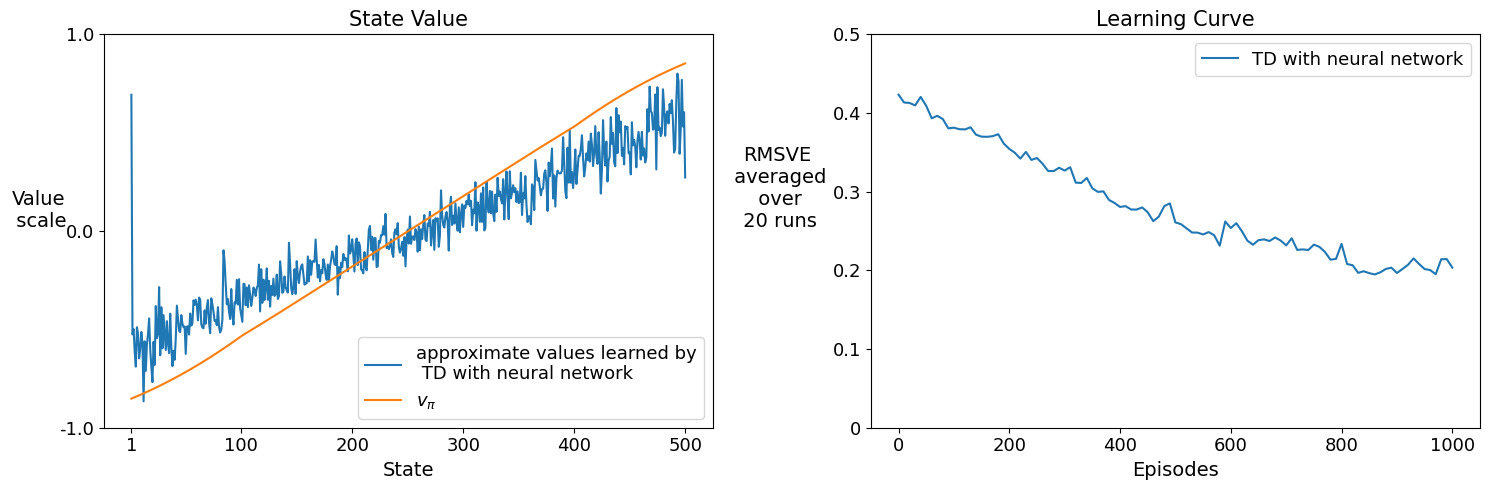

'/content/results.zip'

In [ ]:
# ---------------
# Discussion Cell
# ---------------

true_state_val = np.load('/content/true_V.npy')
state_distribution = np.load('/content/state_distribution.npy')

def calc_RMSVE(learned_state_val):
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

# Define function to run experiment
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)

    # save rmsve at the end of each episode
    agent_rmsve = np.zeros((experiment_parameters["num_runs"],
                            int(experiment_parameters["num_episodes"]/experiment_parameters["episode_eval_frequency"]) + 1))

    # save learned state value at the end of each run
    agent_state_val = np.zeros((experiment_parameters["num_runs"],
                                environment_parameters["num_states"]))

    env_info = {"num_states": environment_parameters["num_states"],
                "start_state": environment_parameters["start_state"],
                "left_terminal_state": environment_parameters["left_terminal_state"],
                "right_terminal_state": environment_parameters["right_terminal_state"]}

    agent_info = {"num_states": environment_parameters["num_states"],
                  "num_hidden_layer": agent_parameters["num_hidden_layer"],
                  "num_hidden_units": agent_parameters["num_hidden_units"],
                  "step_size": agent_parameters["step_size"],
                  "discount_factor": environment_parameters["discount_factor"],
                  "beta_m": agent_parameters["beta_m"],
                  "beta_v": agent_parameters["beta_v"],
                  "epsilon": agent_parameters["epsilon"]
                 }

    print('Setting - Neural Network with 100 hidden units')
    os.system('sleep 1')

    # one agent setting
    for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
        env_info["seed"] = run
        agent_info["seed"] = run
        rl_glue.rl_init(agent_info, env_info)

        # Compute initial RMSVE before training
        current_V = rl_glue.rl_agent_message("get state value")
        agent_rmsve[run-1, 0] = calc_RMSVE(current_V)

        for episode in range(1, experiment_parameters["num_episodes"]+1):
            # run episode
            rl_glue.rl_episode(0) # no step limit

            if episode % experiment_parameters["episode_eval_frequency"] == 0:
                current_V = rl_glue.rl_agent_message("get state value")
                agent_rmsve[run-1, int(episode/experiment_parameters["episode_eval_frequency"])] = calc_RMSVE(current_V)
            elif episode == experiment_parameters["num_episodes"]: # if last episode
                current_V = rl_glue.rl_agent_message("get state value")

        agent_state_val[run-1, :] = current_V

    save_name = "{}".format(rl_glue.agent.name).replace('.','')

    if not os.path.exists('results'):
                os.makedirs('results')

    # save avg. state value
    np.save("results/V_{}".format(save_name), agent_state_val)

    # save avg. rmsve
    np.savez("results/RMSVE_{}".format(save_name), rmsve = agent_rmsve,
                                                   eval_freq = experiment_parameters["episode_eval_frequency"],
                                                   num_episodes = experiment_parameters["num_episodes"])


# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 20,
    "num_episodes" : 1000,
    "episode_eval_frequency" : 10 # evaluate every 10 episode
}

# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "discount_factor" : 1.0
}

# Agent parameters
agent_parameters = {
    "num_hidden_layer": 1,
    "num_hidden_units": 100,
    "step_size": 0.001,
    "beta_m": 0.9,
    "beta_v": 0.999,
    "epsilon": 0.0001,
}

current_env = RandomWalkEnvironment
current_agent = TDAgent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

# plot result
plot_script.plot_result(["td_agent"])

shutil.make_archive('results', 'zip', 'results')

You plotted the learning curve for 1000 episodes. As you can see the RMSVE is still decreasing. Here we provide the pre-computed result for 5000 episodes and 20 runs so that you can see the performance of semi-gradient TD with a neural network after being trained for a long time.

![](nn_5000_episodes.png)


Does semi-gradient TD with a neural network find a good approximation within 5000 episodes?

As you may remember from the previous assignment, semi-gradient TD with 10-state aggregation converged within 100 episodes. Why is TD with a neural network slower?

Would it be faster if we decrease the number of hidden units? Or what about if we increase the number of hidden units?

## 2-2: Compare Performance of Semi-gradient TD with a Neural Network and Semi-gradient TD with Tile-coding

In this section, we compare the performance of semi-gradient TD with a Neural Network and semi-gradient TD with tile-coding. Tile-coding is a kind of coarse coding that uses multiple overlapping partitions of the state space to produce features. For tile-coding, we used 50 tilings each with 6 tiles. We set the step-size for semi-gradient TD with tile-coding to $\frac{0.1}{\text{# tilings}}$. See the figure below for the comparison between semi-gradient TD with tile-coding and semi-gradient TD with a neural network and Adam algorithm. This result is for 5000 episodes and 20 runs:
![](nn_vs_tc.png)

How are the results?

Semi-gradient TD with tile-coding is much faster than semi-gradient TD with a neural network. Why?

Which method has a lower RMSVE at the end of 5000 episodes?

### Wrapping up!

You have successfully implemented Course 3 Programming Assignment 2.

You have implemented **semi-gradient TD with a Neural Network and Adam algorithm** in 500-state Random Walk.

You also compared semi-gradient TD with a neural network and semi-gradient TD with tile-coding.

From the experiments and lectures, you should be more familiar with some of the strengths and weaknesses of using neural networks as the function approximator for an RL agent. On one hand, neural networks are powerful function approximators capable of representing a wide class of functions. They are also capable of producing features without exclusively relying on hand-crafted mechanisms. On the other hand, compared to a linear function approximator with tile-coding, neural networks can be less sample efficient. When implementing your own Reinforcement Learning agents, you may consider these strengths and weaknesses to choose the proper function approximator for your problems.